## Setup and Imports

In [1]:
import os
import gzip
from tqdm import tqdm

import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from genometechlab_plotting import setup_style, get_colors
setup_style('inline')

Loaded 7 Helvetica fonts


## Modification Heatmap Analyzer

In [2]:
class ModificationCountAnalyzer:
    
    def __init__(self, modkit_path, bam_path, output_dir):
        self.modkit_path = modkit_path
        self.bam_path = bam_path
        self.output_dir = output_dir
        
        self.mod_types = {
            'm': 'm5C',
            'a': 'm6A', 
            '17802': 'Psi',
            '17596': 'Ino'
        }
        
        self.mod_count = []
        self.read_len = []
    
    def read_id_lengths(self):
        print(f"Reading alignment file: {self.bam_path}")
        af = pysam.AlignmentFile(self.bam_path)
        read_id_dict = {}
        
        for read in tqdm(af.fetch(), desc="Processing BAM file"):
            if read.is_secondary or read.is_supplementary or read.is_unmapped:
                continue
            read_id_dict[read.query_name] = read.query_alignment_length
            
        af.close()
        print(f"Processed {len(read_id_dict)} primary alignments")
        return read_id_dict
    
    def process_modkit_file(self, read_id_dict, max_lines=1000000):
        print(f"Processing modkit file: {self.modkit_path}")
        
        target_mods = {'m', 'a', '17802', '17596'}
        
        read_id = None
        reads = 0
        read_mods = []
        tmp_count = 0
        skipped_mods = 0
        
        try:
            infile = gzip.open(self.modkit_path, 'rt')
            test_line = infile.readline()
            infile.close()
            infile = gzip.open(self.modkit_path, 'rt')
            print("  Detected compressed file format")
        except:
            infile = open(self.modkit_path, 'r')
            print("  Detected uncompressed file format")
        
        try:
            for line in tqdm(infile, desc="Processing modifications"):
                if tmp_count > max_lines:
                    break
                    
                split_line = line.strip().split('\t')
                
                if split_line[0] == 'read_id':
                    continue
                
                if read_id is None:
                    read_id = split_line[0]
                
                if read_id != split_line[0]:
                    if read_id in read_id_dict and len(read_mods) > 0:
                        self.mod_count.append(len(read_mods))
                        self.read_len.append(read_id_dict[read_id])
                    
                    read_id = split_line[0]
                    read_mods = []
                    reads += 1
                
                if split_line[-8] != split_line[-7]:
                    continue
                if split_line[-10] == '-':
                    continue
                if split_line[-4] == 'true':
                    continue
                
                mod_type = split_line[-10]
                if mod_type not in target_mods:
                    skipped_mods += 1
                    continue
                
                read_mods.append((split_line[0], int(split_line[1]), mod_type))
                tmp_count += 1
        
        finally:
            infile.close()
        
        if read_id in read_id_dict and read_mods:
            self.mod_count.append(len(read_mods))
            self.read_len.append(read_id_dict[read_id])
        
        print(f"Processed {reads} reads with {tmp_count} modifications")
        print(f"Skipped {skipped_mods} modifications not in target set")
    
    def plot_length_vs_mods(self):
        df = pd.DataFrame({
            "read_length": self.read_len,
            "mod_count": self.mod_count
        })
        
        print(f"\nData Statistics:")
        print(f"Total reads: {len(df)}")
        print(f"Read length range: {df['read_length'].min()} - {df['read_length'].max()}")
        print(f"Mod count range: {df['mod_count'].min()} - {df['mod_count'].max()}")
        print(f"Mean mod count: {df['mod_count'].mean():.1f}")
        print(f"Median mod count: {df['mod_count'].median():.1f}")
        print(f"95th percentile mod count: {df['mod_count'].quantile(0.95):.0f}")
        print(f"99th percentile mod count: {df['mod_count'].quantile(0.99):.0f}")
        
        df = df[df["read_length"] <= 8000]
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
        max_mod_count = df['mod_count'].max()
        
        x_bins = np.linspace(0, 8000, 80)
        y_bins = np.linspace(0, max_mod_count + 5, min(100, max_mod_count + 5))
        
        density = ax.hist2d(
            x=df['read_length'].values,
            y=df['mod_count'].values,
            cmap='plasma',
            norm=colors.LogNorm(vmin=1),
            bins=[x_bins, y_bins],
            cmin=1
        )
        
        fig.colorbar(density[3], label='Number of reads')
        ax.grid(True, alpha=0.3)
        plt.xlabel('Aligned Read Length')
        plt.ylabel('Modification Count (4 types only)')
        plt.title(f'Read Length vs Modification Count\nMax mod count: {max_mod_count}')

        if self.output_dir is not None:
            output_path = os.path.join(self.output_dir, 'read_length_vs_mod_count.pdf')
            fig.savefig(output_path, bbox_inches='tight')
            print(f"Saved: {output_path}")
        plt.show()
        plt.close()
    
    def run_analysis(self, max_lines=20_000_00):
        if self.output_dir is not None:
            os.makedirs(self.output_dir, exist_ok=True)
        
        read_id_dict = self.read_id_lengths()
        self.process_modkit_file(read_id_dict, max_lines)
        
        print("Generating heatmap...")
        self.plot_length_vs_mods()
        
        print("Analysis complete!")

## Paths

In [3]:
# Input file paths
MODKIT_PATH = "../Exemplar_Data/modkit/08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000_extract_calls.tsv"  # Can be .gz or .tsv
BAM_PATH = "../Exemplar_Data/bam/08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000.bam"
OUTPUT_DIR = None

# Processing parameters
MAX_LINES = 10_000_000  # Maximum number of modification lines to process

## Run Analysis

Reading alignment file: ../Exemplar_Data/bam/08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000.bam


Processing BAM file: 24566it [00:00, 85133.59it/s] 


Processed 24566 primary alignments
Processing modkit file: ../Exemplar_Data/modkit/08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000_extract_calls.tsv
  Detected compressed file format


Processing modifications: 27951482it [00:52, 532455.18it/s]


Processed 24565 reads with 41306 modifications
Skipped 16566 modifications not in target set
Generating heatmap...

Data Statistics:
Total reads: 4696
Read length range: 86 - 9737
Mod count range: 1 - 75
Mean mod count: 8.8
Median mod count: 7.0
95th percentile mod count: 23
99th percentile mod count: 34


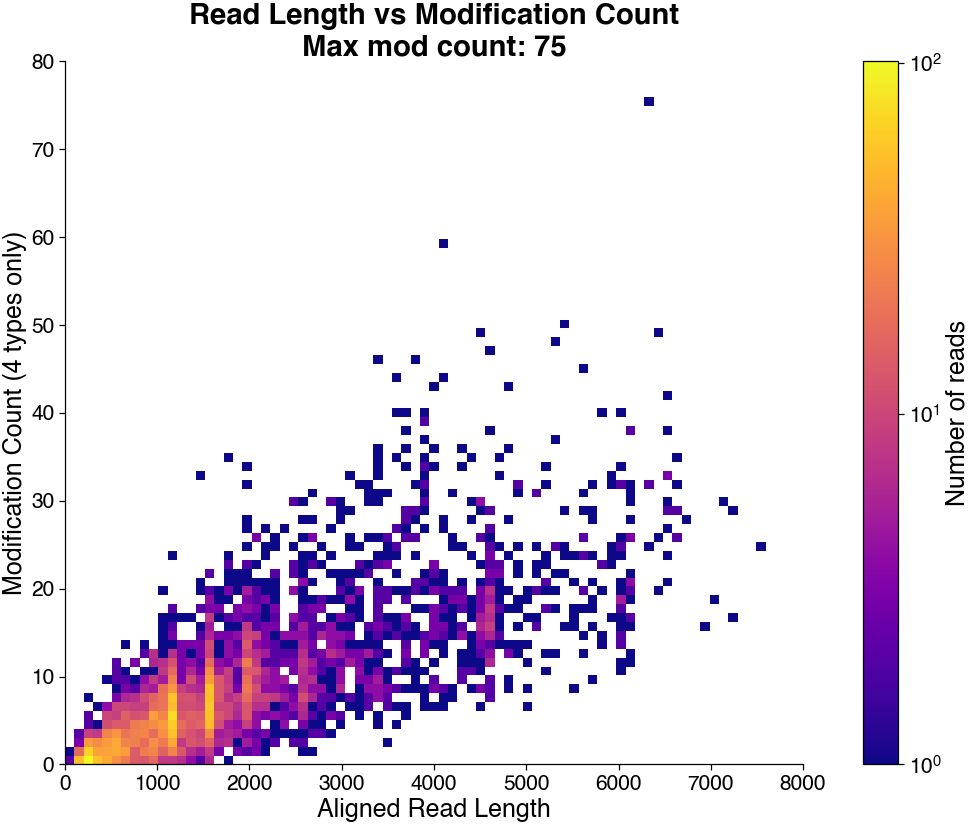

Analysis complete!


In [4]:
%matplotlib inline
# Create analyzer and run analysis
analyzer = ModificationCountAnalyzer(MODKIT_PATH, BAM_PATH, OUTPUT_DIR)
analyzer.run_analysis(max_lines=MAX_LINES)